In [2]:

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import pickle
import thresholding
import skimage.io as skimage

%matplotlib inline

# Camera calibration
### Compute camera calibration parameters and pickle dump them (run only once takes time)

In [52]:
cal_images = glob.glob('./camera_cal/*.jpg')
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


# Step through the list and search for chessboard corners
for idx, fname in enumerate(cal_images):
    nx, ny = 6, 9
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If did not found image points try with 5, 9
    if not ret:
        nx, ny = 5, 9
        objp = np.zeros((nx*ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


test_image = mpimage.imread('./test_images/test1.jpg')
img_size = (test_image.shape[1], test_image.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open('camera_cal/camera_cal_pickle.p', 'wb'))



# Load Camera matrix and distortion coeffs

In [3]:
camdata = pickle.load(open('./camera_cal/camera_cal_pickle.p', 'rb'))
mtx = camdata['mtx']
dist = camdata['dist']
persp = pickle.load(open('./camera_cal/persp_pickle.p', 'rb'))
M = persp['M']
Minv = persp['Minv']

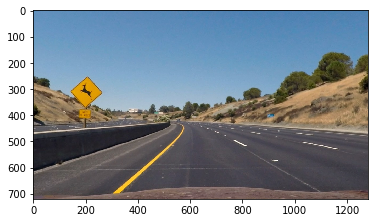

In [6]:
def undistort_image(img_arr, matrix, coeffs):
    return cv2.undistort(img_arr, matrix, coeffs, None, matrix)

# test on a sample image
plt.imshow(undistort_image(mpimage.imread('./test_images/test2.jpg'), mtx, dist))

def perspective_change(imarr, matrix):
    return cv2.warpPerspective(imarr, matrix, (imarr.shape[1], imarr.shape[0]))

# Image Perspective transform

### Hand picked source and destination points and Perspective transform matrices

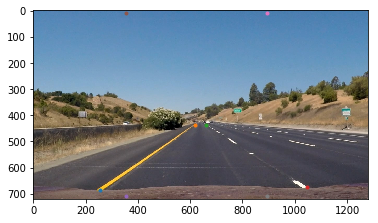

In [15]:
srcpts = np.float32([[254, 686], [617, 439], [661, 439], [1046, 676]])
dstpts = np.float32([[353, 718], [353, 10],  [894, 10], [894, 718]])


src_image = mpimage.imread('./test_images/straight_lines1.jpg')

plt.imshow(src_image)
plt.plot(254, 686, '.')
plt.plot(617, 439, '.')
plt.plot(661, 439, '.')
plt.plot(1046, 676, '.')

plt.plot(353, 710, '.')
plt.plot(353, 10, '.')
plt.plot(894, 10, '.')
plt.plot(894, 710, '.')


M = cv2.getPerspectiveTransform(srcpts, dstpts)
Minv = cv2.getPerspectiveTransform(dstpts, srcpts)

persp_pickle = {}
persp_pickle["M"] = M
persp_pickle["Minv"] = Minv
pickle.dump(persp_pickle, open('camera_cal/persp_pickle.p', 'wb'))



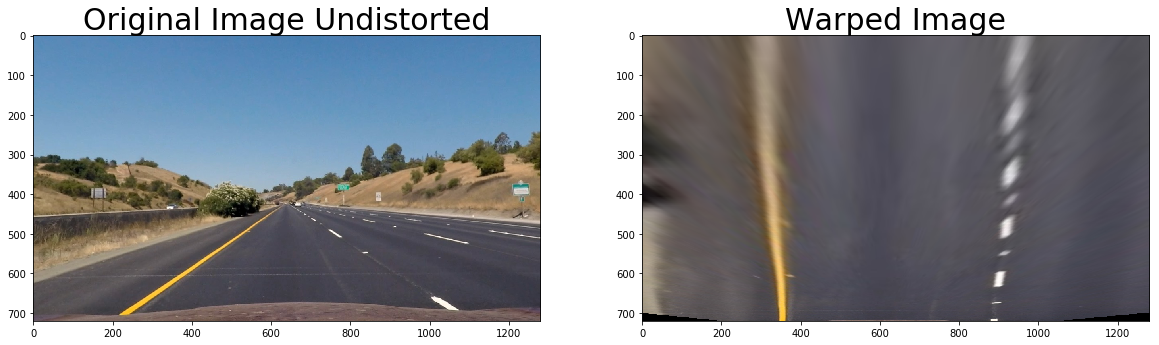

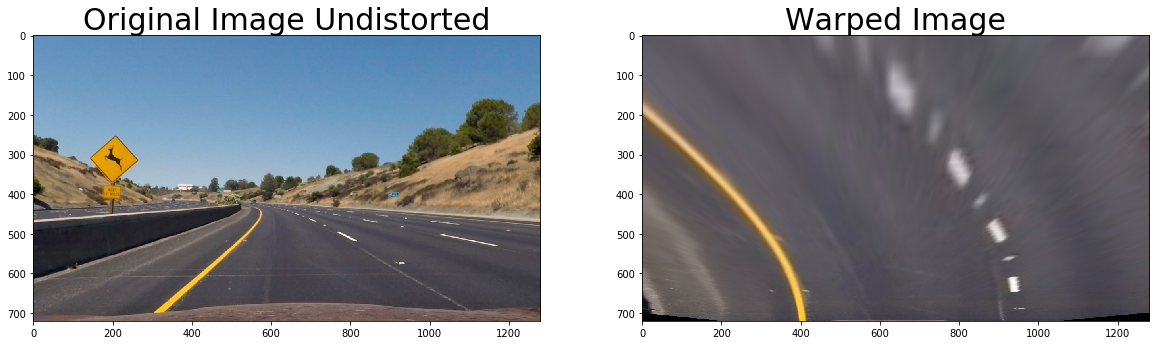

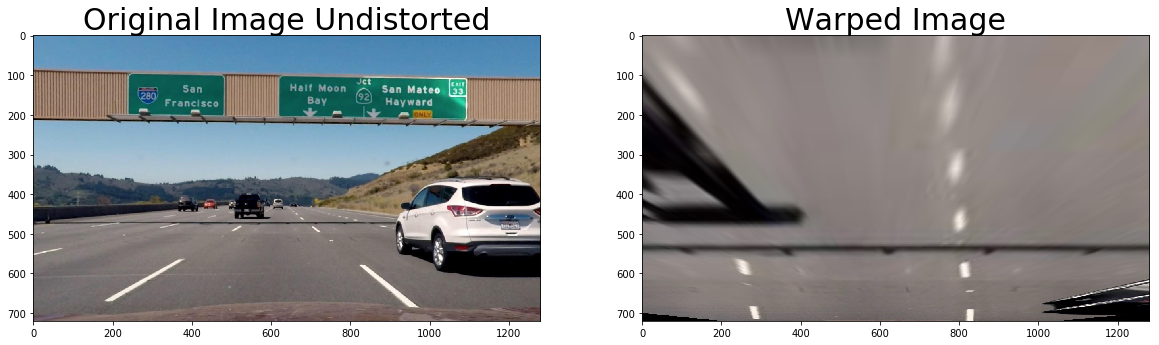

In [10]:
undist = undistort_image(src_image, mtx, dist)
warp_image = cv2.warpPerspective(undist, M, (src_image.shape[1], src_image.shape[0]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Original Image Undistorted', fontsize=30)
ax2.imshow(warp_image)
ax2.set_title('Warped Image', fontsize=30)

curved = mpimage.imread('./test_images/test2.jpg')
undist = undistort_image(curved, mtx, dist)
warp_image = cv2.warpPerspective(undist, M, (curved.shape[1], curved.shape[0]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Original Image Undistorted', fontsize=30)
ax2.imshow(warp_image)
ax2.set_title('Warped Image', fontsize=30)

other_image = mpimage.imread('./test_images/signs_vehicles_xygrad.jpg')
undist = undistort_image(other_image, mtx, dist)
warp_image = cv2.warpPerspective(undist, M, (curved.shape[1], curved.shape[0]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Original Image Undistorted', fontsize=30)
ax2.imshow(warp_image)
ax2.set_title('Warped Image', fontsize=30)



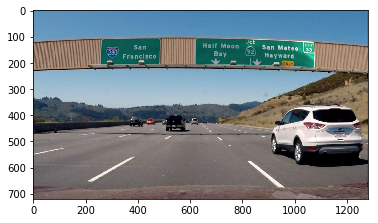

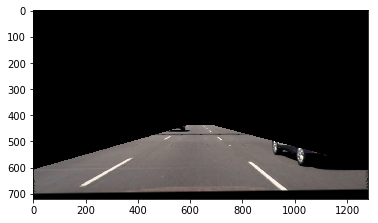

In [11]:
unwarp_image = cv2.warpPerspective(warp_image, Minv, (warp_image.shape[1], warp_image.shape[0]))
plt.figure()
plt.imshow(other_image)
plt.figure()
plt.imshow(unwarp_image)

# Gradient and Color Thresholding

## Example image used in the cells in this section

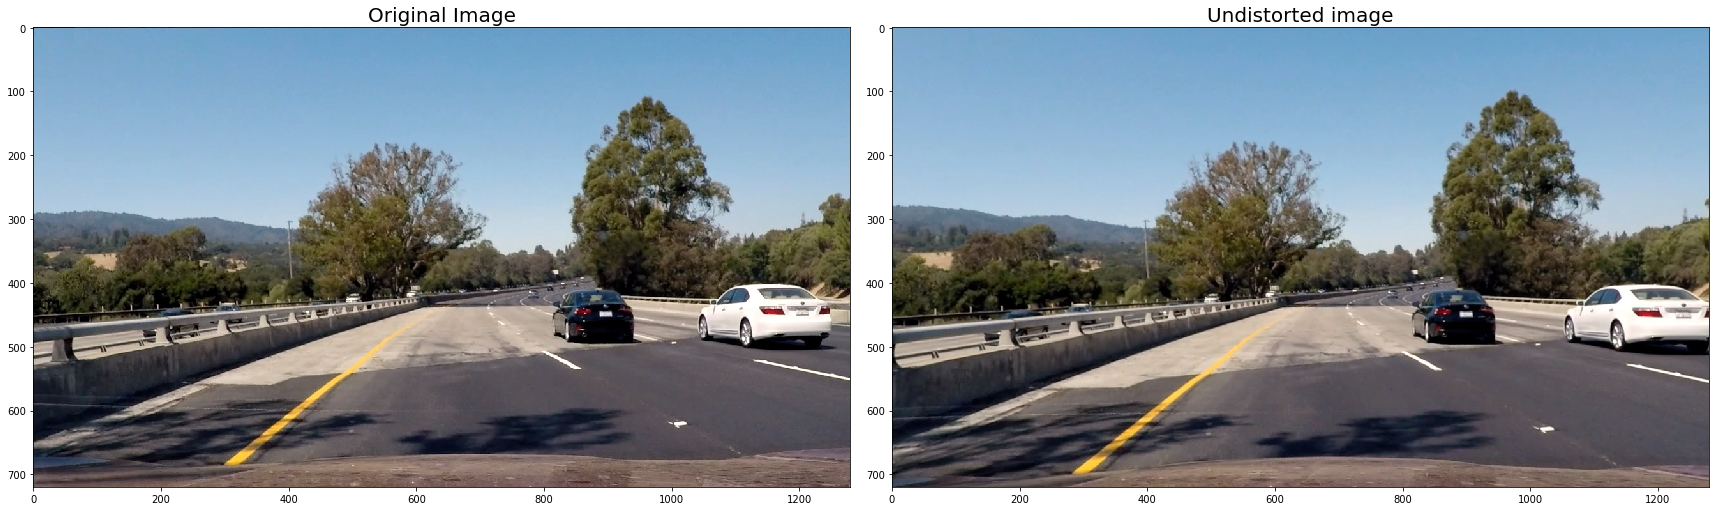

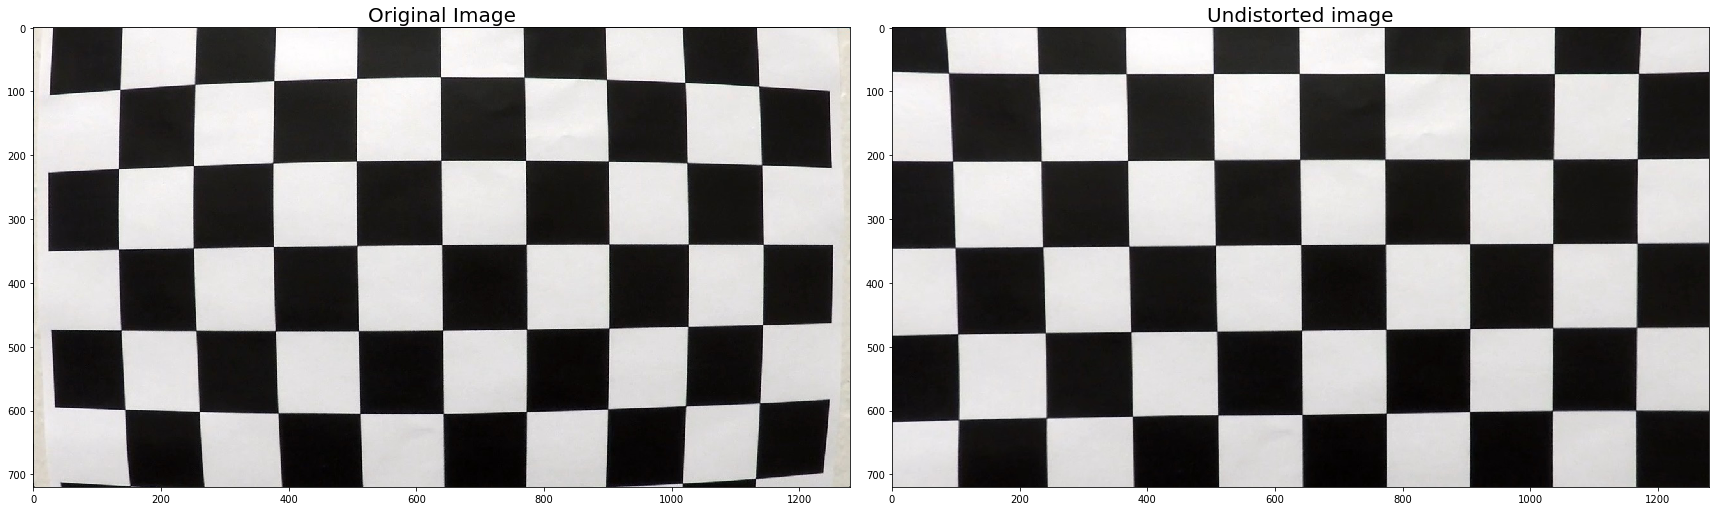

In [71]:
# Test image
# orig_image = mpimage.imread('./test_images/signs_vehicles_xygrad.jpg')
orig_image = mpimage.imread('./test_images/test4.jpg')

image = undistort_image(orig_image, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orig_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(image)
ax2.set_title('Undistorted image', fontsize=20)

chessboard = mpimage.imread('./camera_cal/calibration1.jpg')
undist_chessboard = undistort_image(chessboard, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(chessboard)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist_chessboard)
ax2.set_title('Undistorted image', fontsize=20)


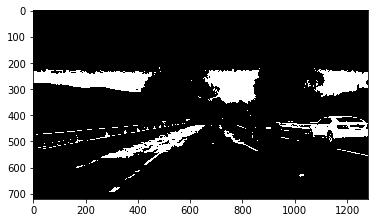

In [116]:
def white_threshold(img, low, high):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    zeros = np.zeros_like(gray)
    zeros[(gray > low) & (gray <= high)] = 1
    return zeros

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255, kernel_size=3, hls=False):
    # Convert to grayscale
    if hls:
        hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = hls_image[:,:,1]
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(abs_sobel/np.max(abs_sobel)*255)
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

white_thresholded = white_threshold(image, 190, 255)
plt.imshow(white_thresholded, cmap='gray')

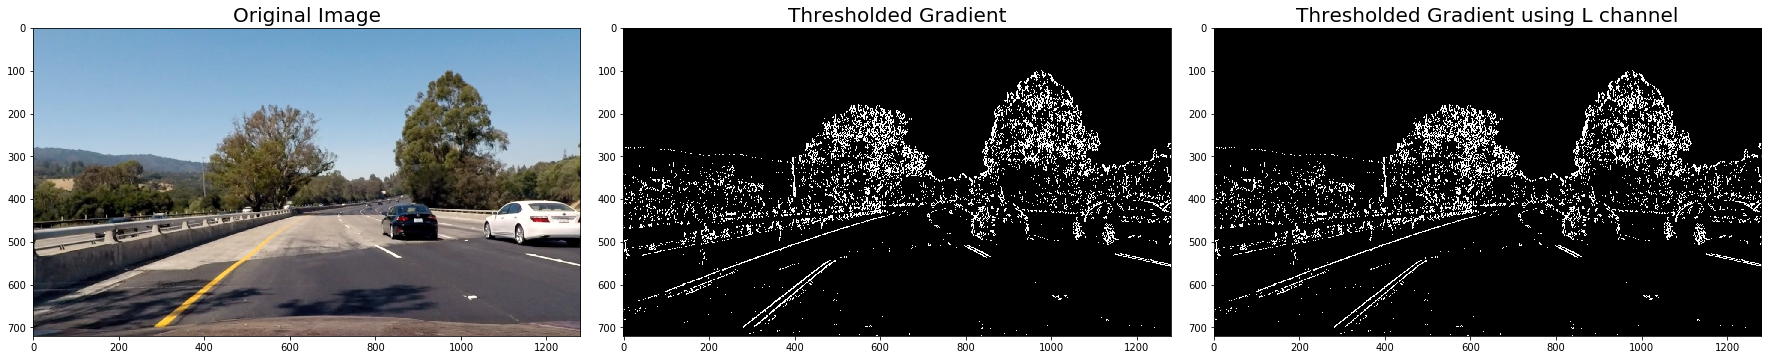

In [97]:
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
grad_binary_hls = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100, hls=True)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=20)
ax3.imshow(grad_binary_hls, cmap='gray')
ax3.set_title('Thresholded Gradient using L channel', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

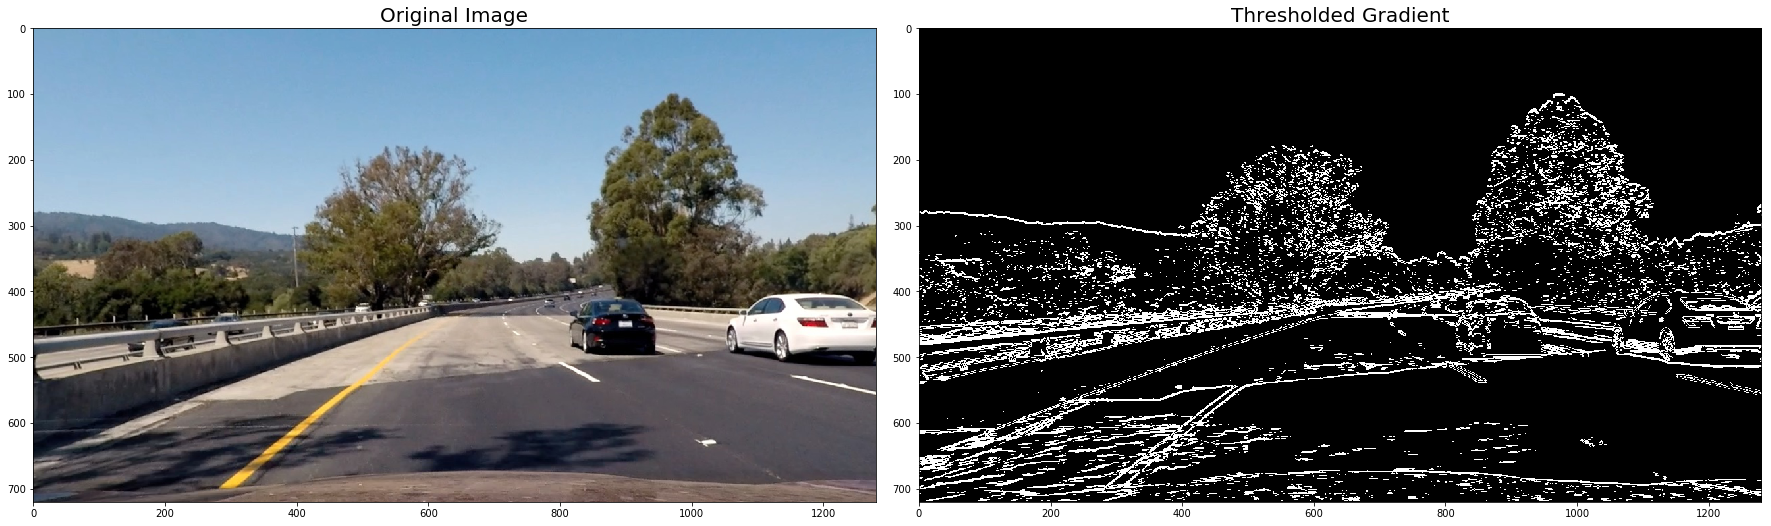

In [74]:
# Run the function
grad_binary = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [75]:
def magnitude_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    gradmag = (gradmag/np.max(gradmag)*255).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


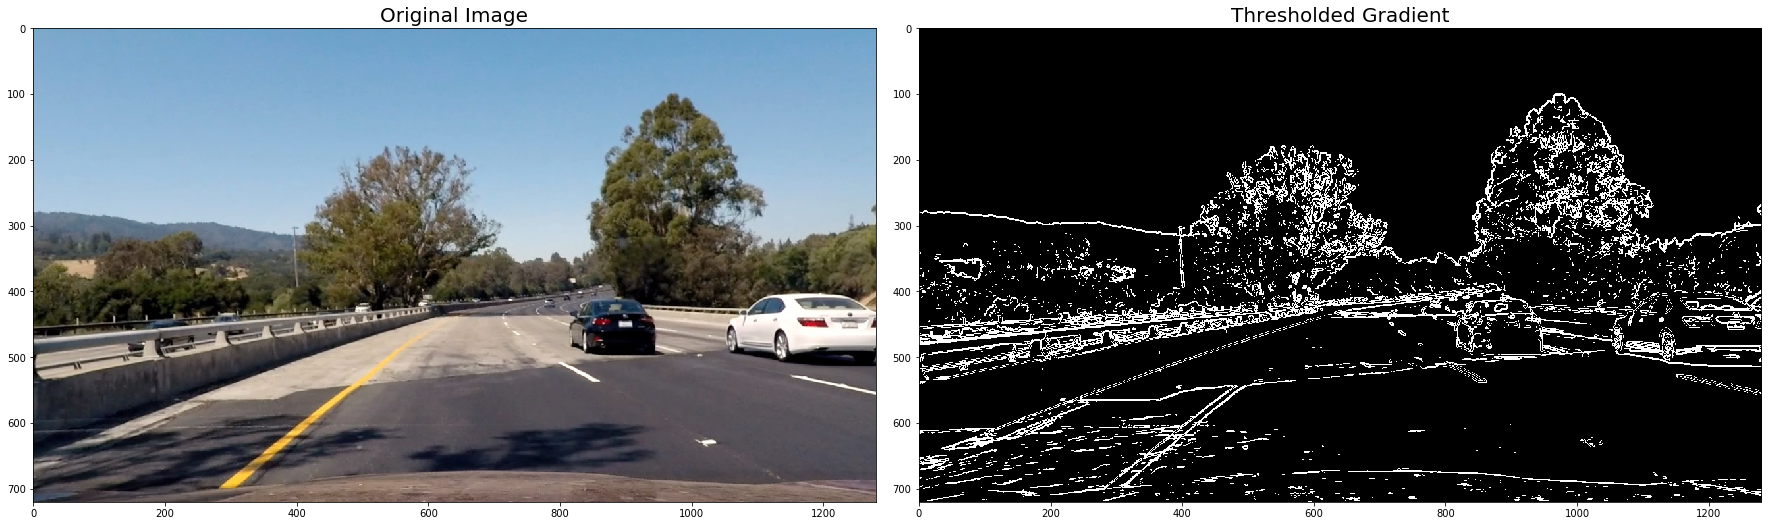

In [76]:
# Run the function
mag_binary = magnitude_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [77]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

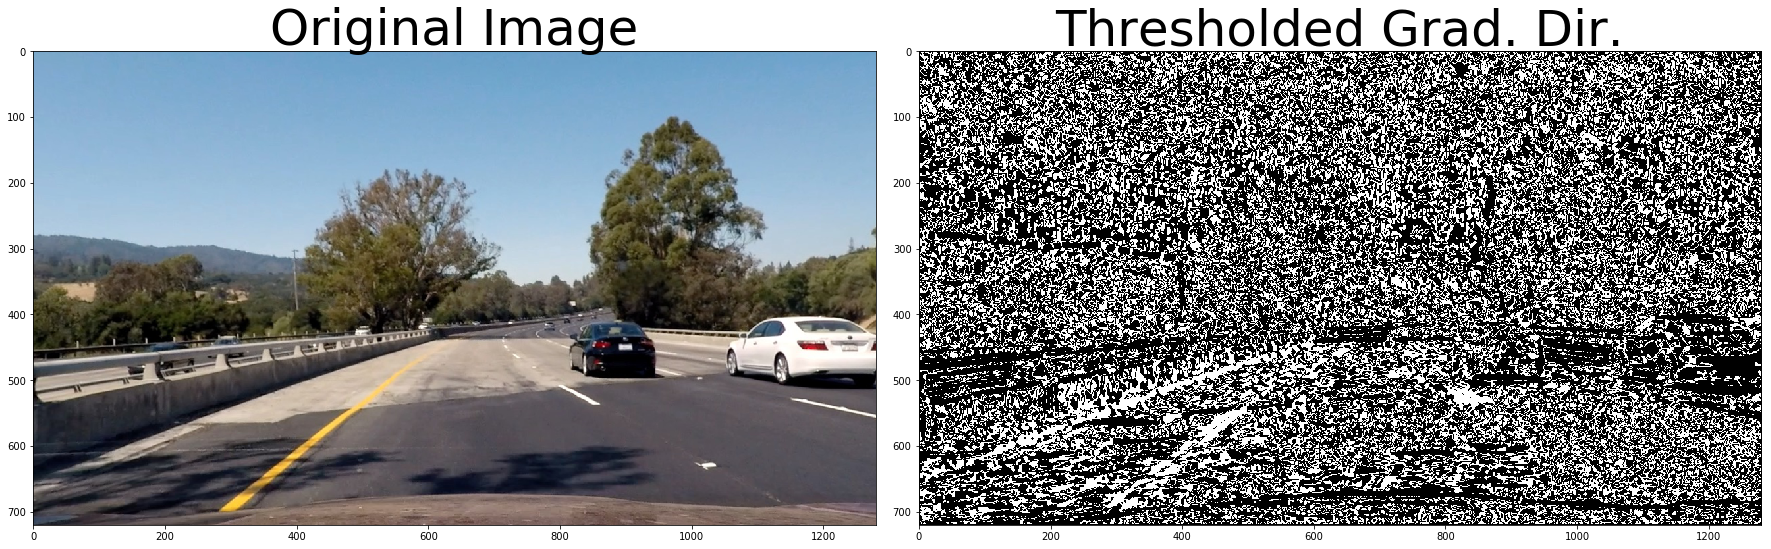

In [78]:
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combined direction, magnitude and absolute gradients

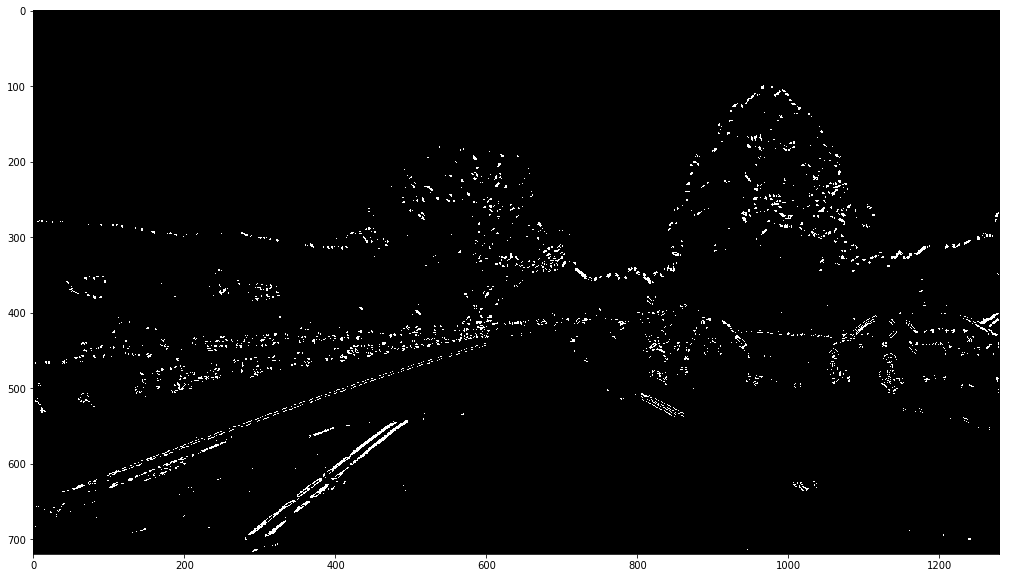

In [128]:

gradx_binary = abs_sobel_thresh(image, orient='x', thresh_min=30, thresh_max=100, kernel_size=9)
grady_binary = abs_sobel_thresh(image, orient='y', thresh_min=40, thresh_max=100, kernel_size=9)
mag_binary = magnitude_thresh(image, sobel_kernel=5, mag_thresh=(50, 100))
dir_binary = dir_threshold(image, sobel_kernel=7, thresh=(1.2, 1.3))

combined = combined = np.zeros_like(dir_binary)
combined[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.figure(figsize=(20,10))
plt.imshow(combined, cmap='gray')
plt.imsave('./writeup_images/signs_vehicles_xygrad_binary.jpg', combined, cmap='gray')


### HLS color space

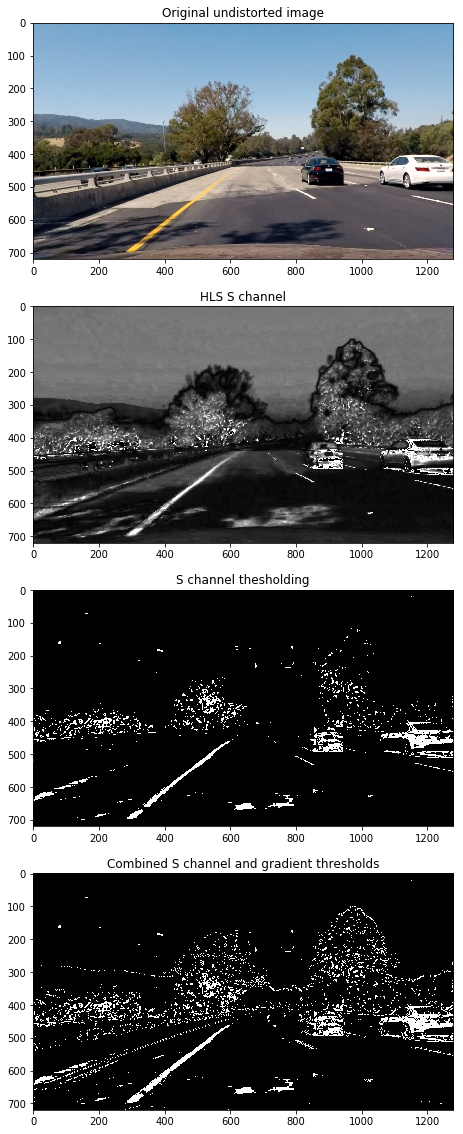

In [101]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
import PIL

s_thresh_min = 130
s_thresh_max = 255

s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= 255)] = 1

color_and_gradient = np.zeros_like(s_channel)
color_and_gradient[(s_binary == 1) | (combined == 1)] = 255
plt.imsave('./writeup_images/gradient_and_color_thresh.jpeg', color_and_gradient, cmap='gray')
f, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))

axes[0].set_title('Original undistorted image')
axes[0].imshow(image)
axes[1].set_title('HLS S channel')
axes[1].imshow(s_channel, cmap='gray')
axes[2].set_title('S channel thesholding')
axes[2].imshow(s_binary, cmap='gray')
axes[3].set_title('Combined S channel and gradient thresholds')
axes[3].imshow(color_and_gradient, cmap='gray')

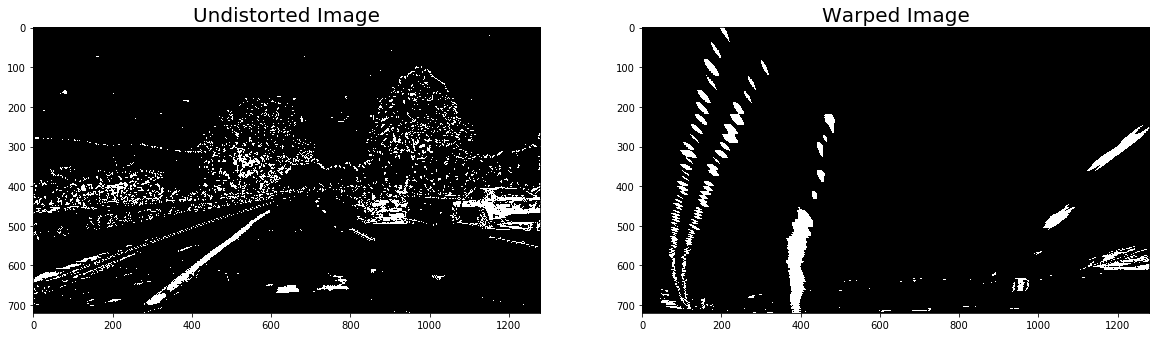

In [81]:
binary_warped = cv2.warpPerspective(color_and_gradient, M, (image.shape[1], image.shape[0]))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(color_and_gradient, cmap='gray')
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=20)



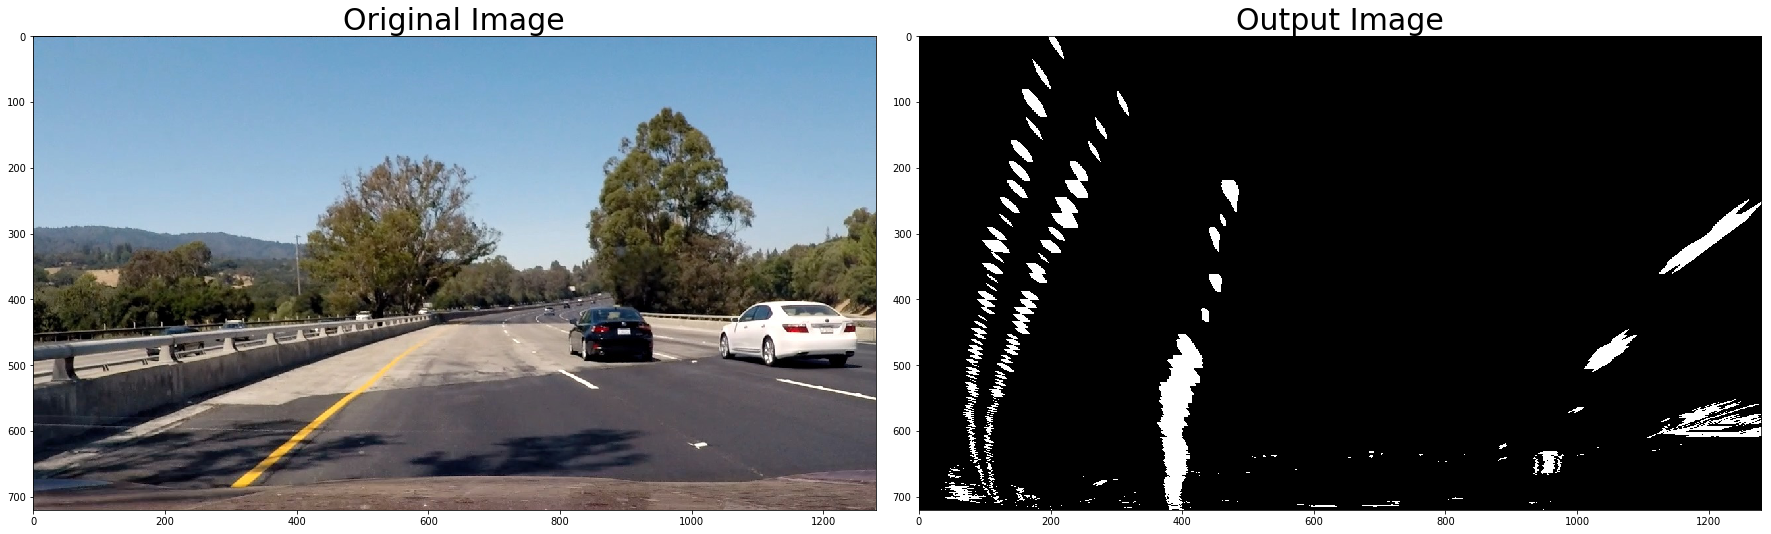

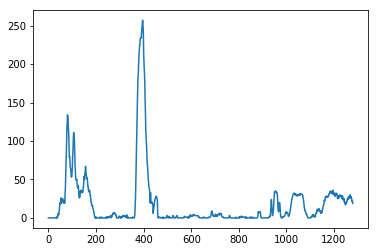

In [82]:
def color_grad_thresh_warp_pipeline(img):
    """
    This function take a image as input and does the following
    - Undistort the image using cam cal data
    - Apply gradient thresholding and color thresholding and combine in a binary image
    - warp the image
    return the result
    """
    _undistorted_img = undistort_image(img, mtx, dist)
    
    
    _gradx_binary = abs_sobel_thresh(_undistorted_img, orient='x', thresh_min=20, thresh_max=100, kernel_size=7)
    
    _grady_binary = abs_sobel_thresh(_undistorted_img, orient='y', thresh_min=30, thresh_max=100, kernel_size=7)
    
    _mag_binary = magnitude_thresh(_undistorted_img, sobel_kernel=5, mag_thresh=(40, 100))
    
    _dir_binary = dir_threshold(_undistorted_img, sobel_kernel=7, thresh=(.9, 1.3))
    
    _combined = np.zeros_like(_dir_binary)
    
    _combined[((_gradx_binary == 1) & (_grady_binary == 1)) | ((_mag_binary == 1) & (_dir_binary == 1))] = 1
    
    _hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    _schannel = _hls[:,:,2]
    _sthresh_min = 130
    _sthresh_max = 255
    _sbinary = np.zeros_like(_schannel)
    _sbinary[(_schannel >= _sthresh_min) & (_schannel <= 255)] = 1

    _color_and_gradient = np.zeros_like(_schannel)
    _color_and_gradient[(_sbinary == 1) | (_combined == 1)] = 1
    return perspective_change(_color_and_gradient, M)


input_img = mpimage.imread('./test_images/test4.jpg')
# res = pipeline.color_grad_thresh_warp_pipeline(input_img, mtx, dist, M)
res = color_grad_thresh_warp_pipeline(input_img)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(input_img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(res, cmap='gray')
ax2.set_title('Output Image', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.figure()
histogram = np.sum(res[res.shape[0]//2:,:], axis=0)
plt.plot(histogram)

# Find the lane

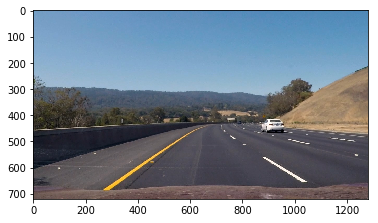

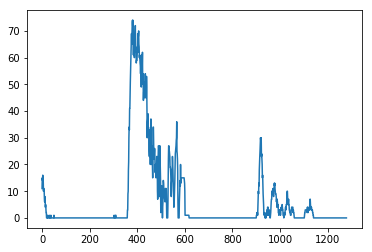

In [22]:
lanes_image = plt.imread('./test_images/test3.jpg')
plt.figure()
plt.imshow(lanes_image)
binary_warped = thresholding.threshold(lanes_image, mtx, dist, M)
mpimage.imsave('./output_images/binary_warped_test3.jpg', binary_warped, cmap='gray')

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.figure()
plt.plot(histogram)

<class 'tuple'>
[219 219 219 ..., 719 719 719]


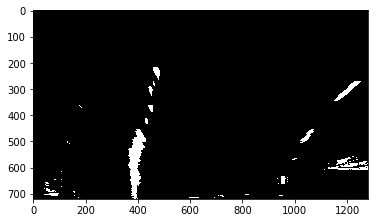

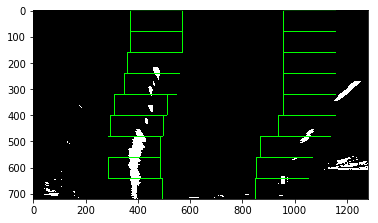

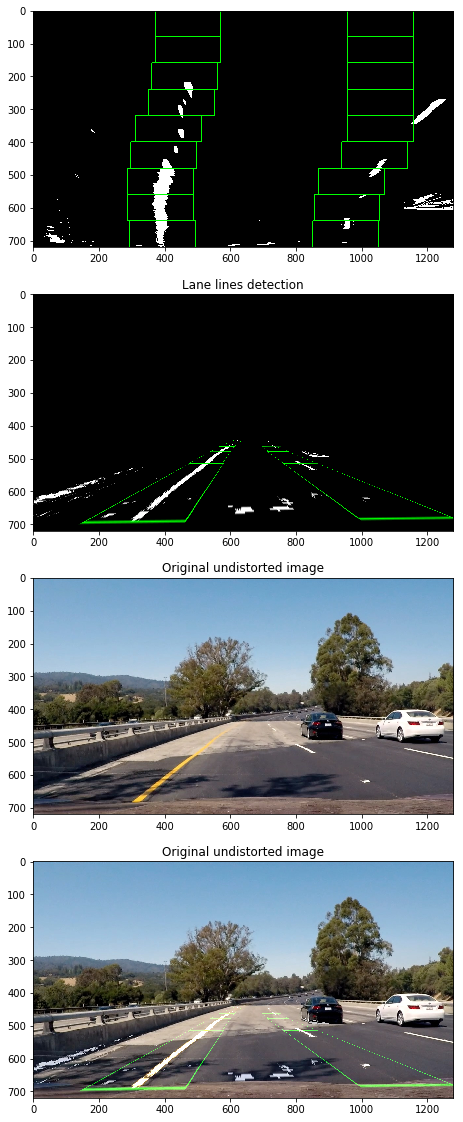

In [7]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0] / 2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0] / nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
print(type(nonzero))
nonzeroy = np.array(nonzero[0])
print(nonzeroy)
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window + 1) * window_height
    win_y_high = binary_warped.shape[0] - window * window_height

    # left window
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    # right window
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                  (win_xleft_high, win_y_high), (0, 255, 0), 2)
    cv2.rectangle(out_img, (win_xright_low, win_y_low),
                  (win_xright_high, win_y_high), (0, 255, 0), 2)

    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (
        nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]

    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (
        nonzerox >= win_xright_low) & (
            nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # update the window center position for the next iteration
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
# left lane line pixels
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]

# right lane line pixels
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

# left line x coordinates
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right line x coordinates
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure()
plt.imshow(binary_warped, cmap='gray')
plt.figure()
plt.imshow(out_img)

# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.imshow(out_img)
# ax2.imshow(perspective_change(out_img, Minv))

f, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))

axes[0].imshow(out_img, cmap='gray')
axes[1].set_title('Lane lines detection')
axes[1].imshow(perspective_change(out_img, Minv))
axes[2].set_title('Original undistorted image')
axes[2].imshow(lanes_image)
axes[3].set_title('Original undistorted image')
axes[3].imshow(weighted_img(lanes_image, perspective_change(out_img, Minv)))

plt.imsave('./output_images/lines_detected.jpg', weighted_img(lanes_image, perspective_change(out_img, Minv)))


820.203015495 489.34642527


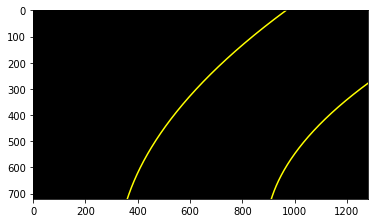

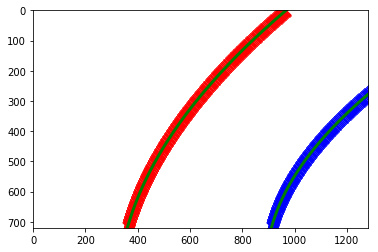

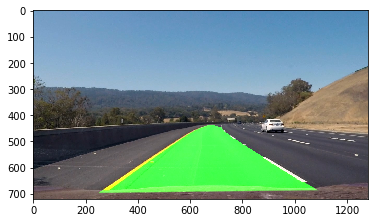

In [23]:
import lanefinder
# binary_warped = plt.imread('./test_images/warped_example.jpg')
laneDetector = lanefinder.LaneDetector()
laneDetector.detect(binary_warped)
leftx, rightx, ploty = laneDetector.get_lines(binary_warped)
lane = laneDetector.draw_lane_warped(binary_warped)
canvas = np.zeros_like(binary_warped)
plt.imshow(canvas, cmap='gray')

plt.plot(leftx, ploty, color='yellow')
plt.plot(rightx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]

right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure()

# Plot up the fake data
mark_size = 10
plt.plot(leftx, ploty, 'x', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'x', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

lane_on_image = weighted_img(lanes_image, perspective_change(lane, Minv))
plt.imsave('./output_images/test3_lane_on_road.png', lane_on_image)
plt.figure()
plt.imshow(lane_on_image)